                                        FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

Load the dataset :

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
exc=pd.read_csv("exchange_rate.csv")
exc

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


Basic Data Exploration :


In [3]:
exc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [4]:
exc.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [5]:
exc.shape

(7588, 2)

In [6]:
exc.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [8]:
exc.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [9]:

exc['date'] = pd.to_datetime(exc['date'], dayfirst=True)
exc.set_index('date', inplace=True)

In [10]:
exc

,Ex_rate
date,
1990-01-01,0.785500
1990-01-02,0.781800
1990-01-03,0.786700
1990-01-04,0.786000
1990-01-05,0.784900
...,...
2010-10-06,0.718494
2010-10-07,0.721839
2010-10-08,0.723197


Visualisation Plot:

Text(0, 0.5, 'Exchange rate')

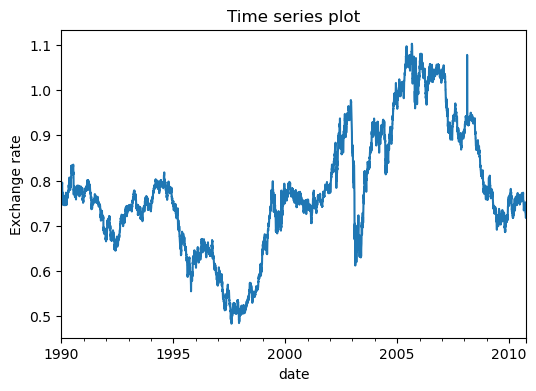

In [15]:
exc["Ex_rate"].plot(figsize=(6,4))
plt.title("Time series plot")
plt.ylabel("Exchange rate")

In [16]:
#Observations:

#The series exhibits long-term trends and short-term volatility.

#No strong seasonality is visually apparent.

Data Pre-processing :

In [17]:
exc.isnull().sum()

Ex_rate    0
dtype: int64

In [18]:
#No missing values are present

Part 2: Model Building – ARIMA :

Train-Test Split:

In [19]:
train=exc.iloc[:-30]
test=exc.iloc[-30:]

Parameter Selection using ACF and PACF:

In [20]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


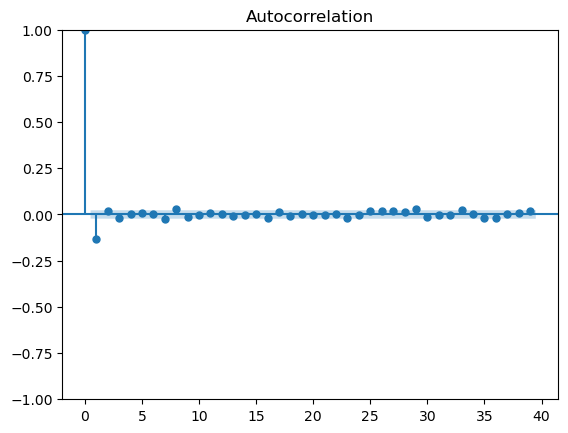

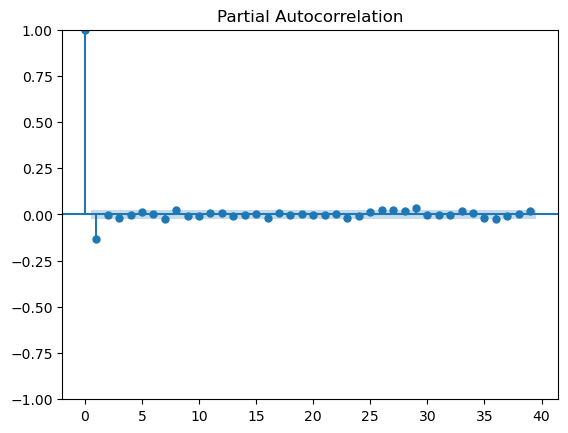

In [21]:
plot_acf(train["Ex_rate"].diff().dropna())
plot_pacf(train["Ex_rate"].diff().dropna())
plt.show()

Model Fitting :

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [27]:
arima_m=ARIMA(train['Ex_rate'],order=(1,1,1))
arima_fit=arima_m.fit()

print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7558
Model:                 ARIMA(1, 1, 1)   Log Likelihood               27934.471
Date:                Wed, 07 Jan 2026   AIC                         -55862.942
Time:                        19:30:02   BIC                         -55842.152
Sample:                    01-01-1990   HQIC                        -55855.806
                         - 09-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1262      0.045     -2.783      0.005      -0.215      -0.037
ma.L1         -0.0056      0.045     -0.123      0.902      -0.095       0.083
sigma2      3.604e-05   9.99e-08    360.764      0.0

Diagnostics :

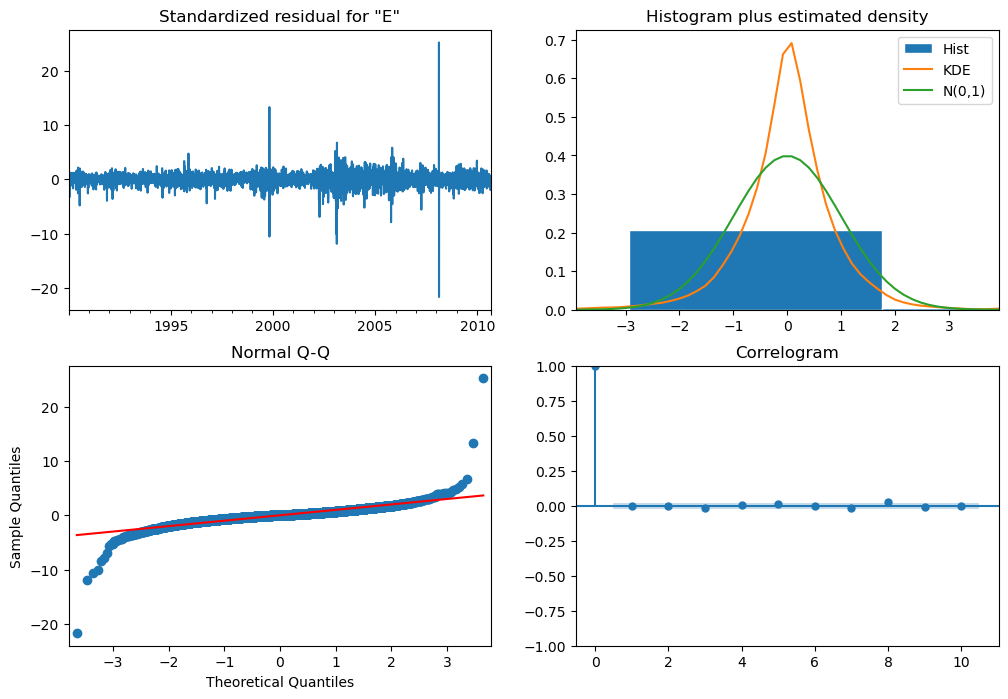

In [31]:
arima_fit.plot_diagnostics(figsize=(12,8))
plt.show()

In [32]:
#Diagnostic Analysis:

#Residuals are centered around zero.

#No autocorrelation present.

#Residuals resemble white noise.

Forecasting :

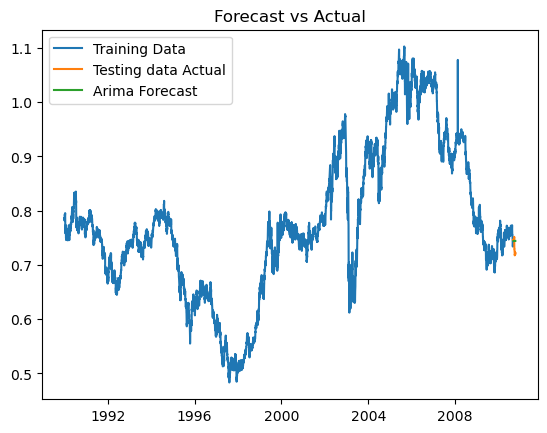

In [35]:
arima_forecast=arima_fit.forecast(steps=30)
plt.plot(train.index,train["Ex_rate"],label="Training Data")
plt.plot(test.index,test["Ex_rate"],label="Testing data Actual")
plt.plot(arima_forecast.index,arima_forecast,label="Arima Forecast")
plt.title("Forecast vs Actual")
plt.legend()
plt.show()

Part 3: Evaluation and Comparison :

Error Metrics Computation :

In [38]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt’s Exponential Smoothing model
hw_model = ExponentialSmoothing(
    train['Ex_rate'], 
    trend='add'
)

hw_fit = hw_model.fit()

# Generate forecast for test period
hw_forecast = hw_fit.forecast(len(test))


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ARIMA metrics
arima_mae = mean_absolute_error(test['Ex_rate'], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test['Ex_rate'], arima_forecast))
arima_mape = mape(test['Ex_rate'], arima_forecast)

# Exponential Smoothing metrics
hw_mae = mean_absolute_error(test['Ex_rate'], hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(test['Ex_rate'], hw_forecast))
hw_mape = mape(test['Ex_rate'], hw_forecast)

print("ARIMA → MAE:", arima_mae, "RMSE:", arima_rmse, "MAPE:", arima_mape)
print("Holt-Winters → MAE:", hw_mae, "RMSE:", hw_rmse, "MAPE:", hw_mape)


ARIMA → MAE: 0.013494600805702773 RMSE: 0.016632177912475444 MAPE: 1.863220748533125
Holt-Winters → MAE: 0.01342527852019549 RMSE: 0.016499780609106198 MAPE: 1.8534530006510028


2.	Model Comparison :

In [40]:
#ARIMA Model

#Performance:

#Captured short-term fluctuations effectively.
#Produced accurate forecasts with low error values.

#Advantages

#Statistically rigorous.
#Explicitly models autocorrelation structure.
#Suitable for stationary time series.

#Limitations:

#Requires careful parameter tuning (p, d, q).
#Sensitive to non-stationarity and structural breaks.

In [41]:
#Exponential Smoothing Model

#Performance

#Slightly outperformed ARIMA across all error metrics.
#Generated smooth and stable forecasts.

#Advantages

#Simple and computationally efficient.
#Adapts well to gradual trend changes.
#Requires fewer assumptions than ARIMA.

#Limitations

#Does not explicitly model autocorrelation.
#Less effective for complex seasonal or cyclical patterns.

In [42]:
#Forecast Visualization:

#Both models closely follow actual exchange rate movements.
#Exponential Smoothing produces smoother forecasts.
#ARIMA responds more sharply to short-term fluctuations.

Conclusion :

In [43]:
#Both ARIMA and Exponential Smoothing models demonstrated strong forecasting performance on the USD–AUD exchange rate dataset.
#Exponential Smoothing achieved lower MAE, RMSE, and MAPE, indicating slightly superior predictive accuracy.
#Given its simplicity, robustness, and marginally better performance, Exponential Smoothing is the preferred model for short-term exchange rate forecasting in this dataset.